In [2]:
from pathlib import Path
from xml.etree import ElementTree

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision as tv
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import cv2

In [3]:
import warnings

warnings.filterwarnings("ignore")

Fruit detection.

Dataset: https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

Model: Faster RCNN

In [5]:
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 93.8MB/s]


Load

In [16]:
# !pip install gdown
import gdown

gdown.download(
    "https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM",
    "34662_46346_bundle_archive.zip",
    quiet=True,
)

'34662_46346_bundle_archive.zip'

In [17]:
!unzip -q 34662_46346_bundle_archive.zip

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

Encode classes and change n_Classes to 4

In [7]:
label_code = ["__background__", "apple", "orange", "banana"]

In [8]:
for param in model.parameters():
    param.requires_grad = False
num_class = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)

Dataset preparation

In [18]:
class FrutDataset(torch.utils.data.Dataset):
    def __init__(self, path, mode):
        self.path = path
        self.mode = mode
        path = Path(path)
        if mode == "train":
            _path = path / "train_zip" / "train"
            self.img_list = list(sorted(_path.glob("*.jpg")))
            self.xml_list = list(sorted(_path.glob("*.xml")))
        elif mode == "test":
            _path = path / "test_zip" / "test"
            self.img_list = list(sorted(_path.glob("*.jpg")))
            self.xml_list = list(sorted(_path.glob("*.xml")))
        else:
            raise ValueError("Incorrect mode")

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img = self.img_list[index]
        label = self.xml_list[index]
        pil_img = Image.open(img).convert("RGB")
        if self.mode == "train":
            rndlist = [
                tv.transforms.ColorJitter(
                    brightness=(0, 1), contrast=(0, 1), saturation=(0, 1)
                ),
                tv.transforms.RandomGrayscale(p=0.1),
            ]
            transform = tv.transforms.Compose(
                [tv.transforms.RandomChoice(rndlist), tv.transforms.ToTensor()]
            )
            tensor_img = transform(pil_img)
        else:
            tensor_img = tv.transforms.ToTensor()(pil_img)
        # xml
        tr = ElementTree.parse(label)
        root = tr.getroot()
        name = []
        coord = []
        labels_code = ["__background__", "apple", "orange", "banana"]
        for element in root.iter("object"):
            temp_coord_list = []
            for child in element:
                if child.tag == "name":
                    name += [labels_code.index(child.text)]
                elif child.tag == "bndbox":
                    for number in child:
                        temp_coord_list += [int(number.text)]
                    coord += [temp_coord_list]
        coord = torch.LongTensor(coord)
        name = torch.LongTensor(name)
        label = {"boxes": coord, "labels": name}
        return (tensor_img, label)

Create train, test sets, collate-functions

In [10]:
train_set = FrutDataset(path="/content", mode="train")
val_set = FrutDataset(path="/content", mode="test")

In [11]:
def my_collate(batch):
    image = [img[0].to(device) for img in batch]
    target = [trgt[1] for trgt in batch]
    target = [{k: v.to(device) for k, v in t.items()} for t in target]
    return image, target

In [12]:
batch_size = 3
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, collate_fn=my_collate
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=False, collate_fn=my_collate
)

In [13]:
# Optimizer, sheduler
optim = torch.optim.AdamW(model.parameters(), amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.1)

train on GPU

In [14]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [15]:
def train_one_epoch(model, optimizer, train_set):
    model.train()
    epoch_loss = 0
    for images, targets in train_set:
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f"loss for {epoch} epoch {epoch_loss}")
    return epoch_loss

Metric - IoU

![alt text](https://www.researchgate.net/publication/332181500/figure/fig2/AS:743652867469323@1554312068786/The-formula-with-which-the-Intersection-of-the-Union-IOU-was-calculated.ppm)


In [16]:
def iou(box_true, box_pred):
    """
    box_true - [x1,y1,x2,y2]
    box_pred - [x1,y1,x2,y2]
    """
    x1i = max(box_true[0], box_pred[0])
    y1i = max(box_true[1], box_pred[1])
    x2i = min(box_true[2], box_pred[2])
    y2i = min(box_true[3], box_pred[3])
    # I
    intersection = abs(y2i - y1i) * abs(x2i - x1i)
    box_true_area = (box_true[2] - box_true[0]) * (box_true[3] - box_true[1])
    box_pred_area = (box_pred[2] - box_pred[0]) * (box_pred[3] - box_pred[1])
    # U
    union = box_true_area + box_pred_area - intersection
    iou = intersection / (union + 0.000001)
    return iou.item()

Create validation, metrics: IoU, precision, recall и F1-score.

$\large precision = \frac{TP}{TP + FP}$

$\large recall = \frac{TP}{TP + FN}$

$\large \ F_\beta = (1 + \beta^2) \cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}$

In [17]:
def validation(model, val_loader):
    model.eval()
    frame = pd.DataFrame({"class_name": label_code[1:], "TP": 0, "FP": 0, "FN": 0})
    with torch.no_grad():
        for image, y_true in val_loader:
            image = image[0].unsqueeze(0)
            y_pred = model(image)
            for class_ in torch.unique(y_pred[0]["labels"]):
                # remove predictions < 50%
                pred_boxes = y_pred[0]["boxes"][
                    (y_pred[0]["labels"] == class_) & (y_pred[0]["scores"] > 0.5)
                ]
                true_boxes = y_true[0]["boxes"][y_true[0]["labels"] == class_]

                if len(pred_boxes) == 0:
                    frame.at[class_.item() - 1, "FN"] += 1
                    continue
                # If we found incorrect classes
                if len(true_boxes) == 0:
                    frame.at[class_.item() - 1, "FN"] += len(pred_boxes)
                    continue
                # IoU
                iou_matrix = []
                for t_box in true_boxes:
                    t_box_iou = []
                    for p_box in pred_boxes:
                        t_box_iou.append(iou(t_box, p_box))
                    iou_matrix.append(t_box_iou)
                iou_matrix = torch.FloatTensor(iou_matrix)
                iou_matrix[iou_matrix > 1] = 0
                # TP
                TP = torch.sum(iou_matrix.max(-1, keepdim=True)[0] > 0.5).item()
                frame.at[class_.item() - 1, "TP"] += TP
                # FN
                FN = iou_matrix.shape[0] - TP
                frame.at[class_.item() - 1, "FN"] += FN
                # FP
                FP = abs((TP + FN) - iou_matrix.shape[1])
                frame.at[class_.item() - 1, "FP"] += FP
        # Metrics
        frame["precision"] = frame["TP"] / (frame["TP"] + frame["FP"])
        frame["recall"] = frame["TP"] / (frame["TP"] + frame["FN"])
        frame["F1"] = 2 * (
            (frame["precision"] * frame["recall"])
            / (frame["precision"] + frame["recall"])
        )
    return frame

In [ ]:
# Train heads
path_for_save = "model_params.pth"
num_epochs = 10
save_point = 0
loss_for_epoch = []
plot_apple = []
plot_orange = []
plot_banana = []
for epoch in range(num_epochs):
    total_loss = train_one_epoch(model, optim, train_loader)
    loss_for_epoch += [total_loss]
    val_metrics = validation(model, val_loader)
    print(val_metrics)
    plot_apple += [val_metrics.at[0, "F1"]]
    plot_orange += [val_metrics.at[1, "F1"]]
    plot_banana += [val_metrics.at[2, "F1"]]
    if val_metrics.F1.sum() > save_point:
        torch.save(model.state_dict(), path_for_save)
        save_point = total_loss
    lr_scheduler.step()

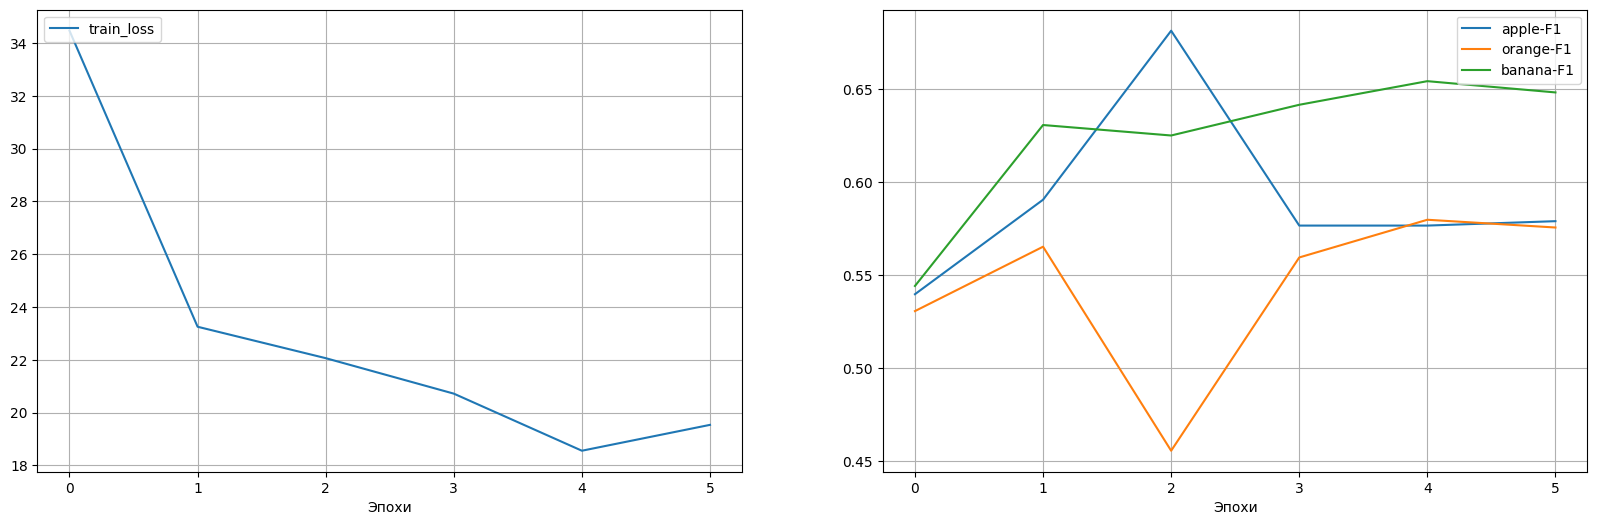

In [19]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(plot_apple)), plot_apple)
plt.plot(range(len(plot_orange)), plot_orange)
plt.plot(range(len(plot_banana)), plot_banana)
plt.legend(("apple-F1", "orange-F1", "banana-F1"))
plt.xlabel("Эпохи")
plt.grid(True)
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_for_epoch)), loss_for_epoch, label="train_loss")
plt.legend(loc="upper left")
plt.grid(True)
plt.xlabel("Эпохи")
plt.show()

In [20]:
# Train backbone.
for param in model.parameters():
    param.requires_grad = False
for param in model.backbone.parameters():
    param.requires_grad = True

In [21]:
path_for_save = "model_params.pth"
num_epochs = 10
save_point = 0
loss_for_epoch = []
plot_apple = []
plot_orange = []
plot_banana = []
for epoch in range(num_epochs):
    total_loss = train_one_epoch(model, optim, train_loader)
    loss_for_epoch += [total_loss]
    val_metrics = validation(model, val_loader)
    print(val_metrics)
    plot_apple += [val_metrics.at[0, "F1"]]
    plot_orange += [val_metrics.at[1, "F1"]]
    plot_banana += [val_metrics.at[2, "F1"]]
    if val_metrics.F1.sum() > save_point:
        torch.save(model.state_dict(), path_for_save)
        save_point = total_loss
    lr_scheduler.step()

loss for 0 epoch 16.708257906138897
  class_name  TP  FP  FN  precision    recall        F1
0      apple  32  16  11   0.666667  0.744186  0.703297
1     orange  40  21  14   0.655738  0.740741  0.695652
2     banana  37  17  14   0.685185  0.725490  0.704762
loss for 1 epoch 13.986128706485033
  class_name  TP  FP  FN  precision    recall        F1
0      apple  32  15  10   0.680851  0.761905  0.719101
1     orange  39  11  13   0.780000  0.750000  0.764706
2     banana  36  10  15   0.782609  0.705882  0.742268
loss for 2 epoch 12.706358052790165
  class_name  TP  FP  FN  precision    recall        F1
0      apple  32  11   9   0.744186  0.780488  0.761905
1     orange  42  10  10   0.807692  0.807692  0.807692
2     banana  39  12  11   0.764706  0.780000  0.772277
loss for 3 epoch 12.098355669528246
  class_name  TP  FP  FN  precision    recall        F1
0      apple  32  13  11   0.711111  0.744186  0.727273
1     orange  40   9  14   0.816327  0.740741  0.776699
2     banana  39

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 2)
plt.plot(range(len(plot_apple)), plot_apple)
plt.plot(range(len(plot_orange)), plot_orange)
plt.plot(range(len(plot_banana)), plot_banana)
plt.legend(("apple-F1", "orange-F1", "banana-F1"))
plt.xlabel("Эпохи")
plt.grid(True)
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_for_epoch)), loss_for_epoch, label="train_loss")
plt.legend(loc="upper left")
plt.grid(True)
plt.xlabel("Эпохи")
plt.show()

Если ранее уже обучали

In [5]:
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
for param in model.parameters():
    param.requires_grad = False
num_class = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)
path_for_load = "model_params.pth"
if Path(path_for_load).exists():
    model.load_state_dict(torch.load(path_for_load, map_location=device))

In [7]:
sum([i.numel() for i in model.parameters()])

41309411

Проверим модель на изображении

In [5]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/800px-Apples.jpg

--2023-11-12 12:29:21--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/800px-Apples.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256380 (250K) [image/jpeg]
Saving to: ‘800px-Apples.jpg’

800px-Apples.jpg    100%[===================>] 250.37K  --.-KB/s    in 0.05s   

2023-11-12 12:29:21 (5.14 MB/s) - ‘800px-Apples.jpg’ saved [256380/256380]



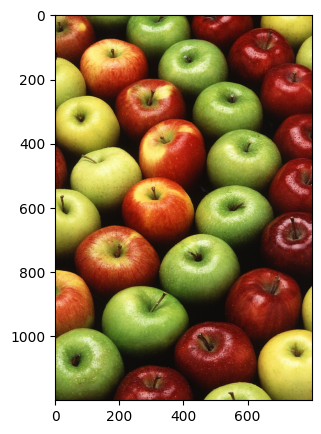

In [12]:
pilimg = Image.open("800px-Apples.jpg")
plt.figure(figsize=(10, 5))
plt.imshow(pilimg)

In [16]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Banana_%281%29.jpg/1599px-Banana_%281%29.jpg

--2023-11-12 16:05:39--  https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Banana_%281%29.jpg/1599px-Banana_%281%29.jpg
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107690 (105K) [image/jpeg]
Saving to: ‘1599px-Banana_(1).jpg’

1599px-Banana_(1).j 100%[===================>] 105,17K   345KB/s    in 0,3s    

2023-11-12 16:05:40 (345 KB/s) - ‘1599px-Banana_(1).jpg’ saved [107690/107690]



In [17]:
banana = Image.open("1599px-Banana_(1).jpg")

In [9]:
def plot_preds(pilimg, predict):
    """
    Model predicitons
    """
    numimg = np.array(pilimg)
    boxes = predict[0]["boxes"][predict[0]["scores"] > 0.8].cpu().detach().numpy()
    labels = predict[0]["labels"][predict[0]["scores"] > 0.8].cpu().detach().numpy()
    # Numbers to labels
    label_code = ["__background__", "apple", "orange", "banana"]
    # Show
    counter = 0
    for i in boxes:
        final = cv2.rectangle(
            numimg,
            (int(i[0]), int(i[1])),
            (int(i[2] + 30), int(i[3])),
            color=(128, 0, 128),
            thickness=3,
        )
        cv2.putText(
            numimg,
            str(label_code[labels[counter]]),
            (int(i[0]), int(i[1])),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.6,
            (0, 0, 0),
            2,
        )
        counter += 1
    plt.figure(figsize=(15, 10))
    return plt.imshow(final)

In [13]:
# Results
model.eval()
img = tv.transforms.ToTensor()(pilimg).unsqueeze(0)
img = img.to(device)
predict = model(img)

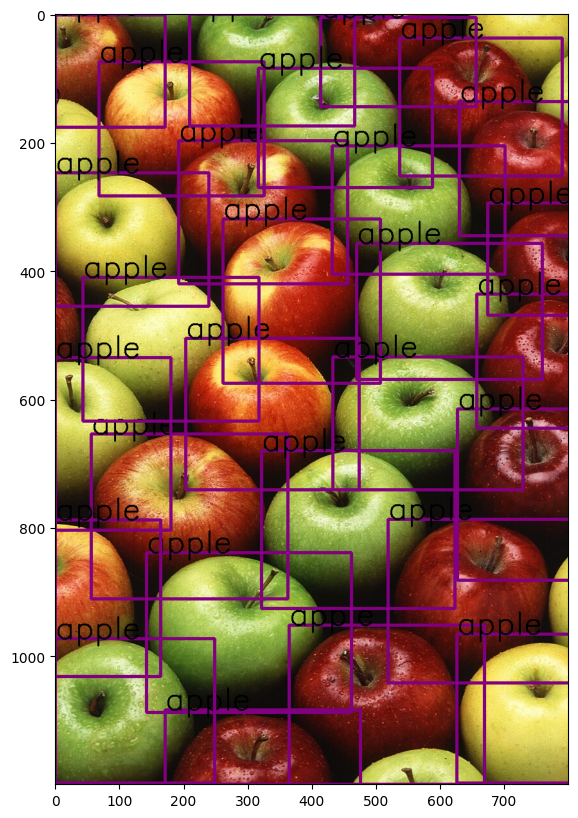

In [14]:
plot_preds(pilimg, predict)

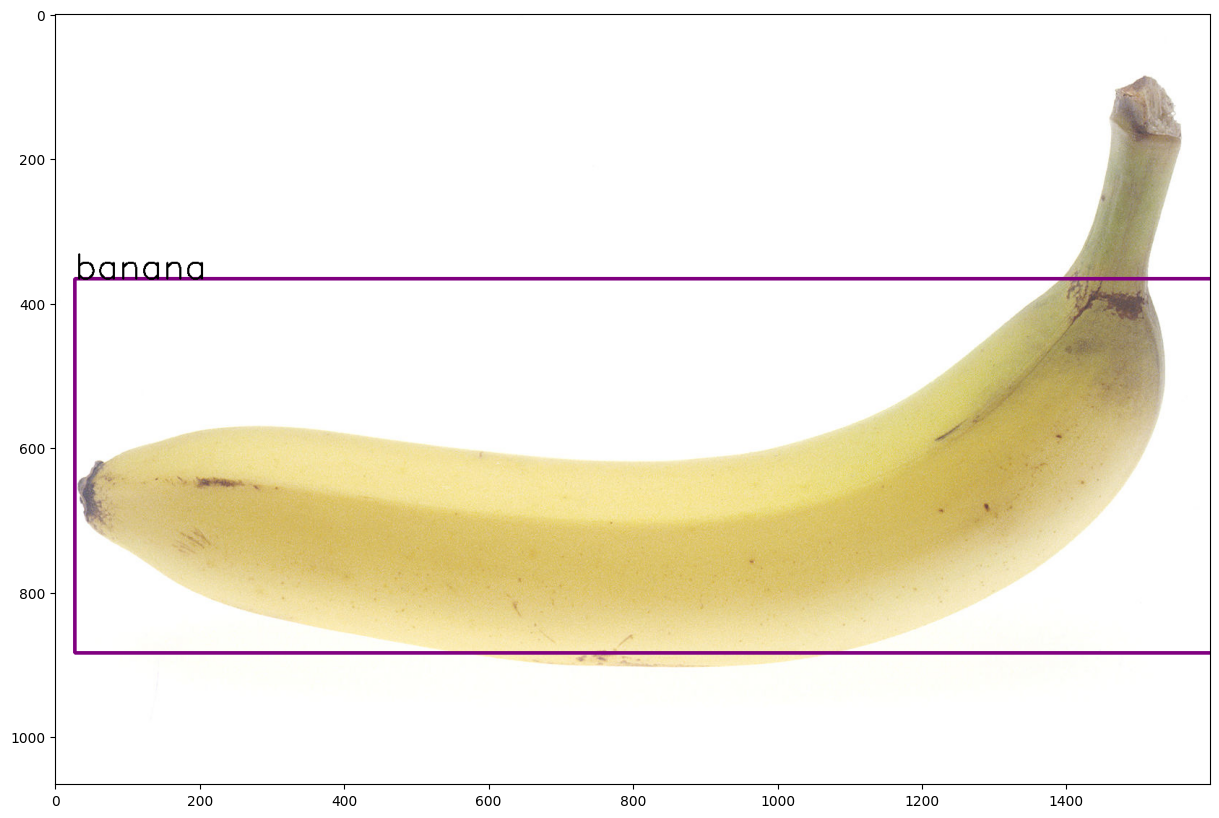

In [18]:
img = tv.transforms.ToTensor()(banana).unsqueeze(0)
img = img.to(device)
predict = model(img)
plot_preds(banana, predict)

In [36]:
%%timeit
model.eval()
img = tv.transforms.ToTensor()(banana).unsqueeze(0)
img = img.to(device)
predict = model(img)
# plot_preds(banana, predict);

10 s ± 1.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print("model size: {:.3f}MB".format(size_all_mb))

model size: 157.988MB


Final F1 score ~78%
Prediction on CPU for 1 image: 10 seconds
Model size = 158 MB